# Introduction
In this notebook, I will be doing similar analysis to the Time Series Analysis notebook: however, in this one, I will be analyzing how the traffic data changes depending on the day of the week, particularly for weekends versus weekdays.

In [1]:
from pyspark.sql import SparkSession, SQLContext
from pyspark.ml.regression import LinearRegression
from pyspark.ml.linalg import Vectors
import pandas as pd
import pyspark.sql.types as T
import pyspark
from scipy import stats
import numpy as np
import pyspark.sql.functions as F
from pyspark.sql.window import Window
import seaborn as sns
import glob
import os
import matplotlib.pyplot as plt
%matplotlib inline

In [2]:
plt.rcParams["axes.titlesize"] = 40
plt.rcParams["axes.labelsize"] = 15

# Part 1: Reading in the Data

In [3]:
data_dir = "../data/uber/uber-trip-data/"
uber_files = glob.glob(data_dir + '*.csv') 
uber_files

['../data/uber/uber-trip-data/uber-raw-data-jun14.csv',
 '../data/uber/uber-trip-data/uber-raw-data-may14.csv',
 '../data/uber/uber-trip-data/taxi-zone-lookup.csv',
 '../data/uber/uber-trip-data/uber-raw-data-jul14.csv',
 '../data/uber/uber-trip-data/uber-raw-data-sep14.csv',
 '../data/uber/uber-trip-data/uber-raw-data-apr14.csv',
 '../data/uber/uber-trip-data/uber-raw-data-aug14.csv']

In [4]:
uber_files.remove('../data/uber/uber-trip-data/taxi-zone-lookup.csv')

In [5]:
spark = SparkSession.builder \
    .master("local") \
    .appName("Word Count") \
    .config("spark.some.config.option", "some-value") \
    .getOrCreate()

22/05/09 13:21:28 WARN Utils: Your hostname, DSGPU05 resolves to a loopback address: 127.0.1.1; using 10.10.11.64 instead (on interface eno1)
22/05/09 13:21:28 WARN Utils: Set SPARK_LOCAL_IP if you need to bind to another address
Using Spark's default log4j profile: org/apache/spark/log4j-defaults.properties
Setting default log level to "WARN".
To adjust logging level use sc.setLogLevel(newLevel). For SparkR, use setLogLevel(newLevel).
22/05/09 13:21:30 WARN NativeCodeLoader: Unable to load native-hadoop library for your platform... using builtin-java classes where applicable
22/05/09 13:21:33 WARN Utils: Service 'SparkUI' could not bind on port 4040. Attempting port 4041.


In [6]:
df = spark.read.csv(uber_files, header=True)

In [7]:
df.show()

+----------------+-------+--------+------+
|       Date/Time|    Lat|     Lon|  Base|
+----------------+-------+--------+------+
|9/1/2014 0:01:00|40.2201|-74.0021|B02512|
|9/1/2014 0:01:00|  40.75|-74.0027|B02512|
|9/1/2014 0:03:00|40.7559|-73.9864|B02512|
|9/1/2014 0:06:00| 40.745|-73.9889|B02512|
|9/1/2014 0:11:00|40.8145|-73.9444|B02512|
|9/1/2014 0:12:00|40.6735|-73.9918|B02512|
|9/1/2014 0:15:00|40.7471|-73.6472|B02512|
|9/1/2014 0:16:00|40.6613|-74.2691|B02512|
|9/1/2014 0:32:00|40.3745|-73.9999|B02512|
|9/1/2014 0:33:00|40.7633|-73.9773|B02512|
|9/1/2014 0:33:00|40.7467|-73.6131|B02512|
|9/1/2014 0:37:00|40.8105|  -73.96|B02512|
|9/1/2014 0:38:00| 40.679|-74.0111|B02512|
|9/1/2014 0:39:00|40.4023|-73.9839|B02512|
|9/1/2014 0:48:00|40.7378|-74.0395|B02512|
|9/1/2014 0:48:00|40.7214|-73.9884|B02512|
|9/1/2014 0:49:00|40.8646|-73.9081|B02512|
|9/1/2014 1:08:00|40.7398|-74.0061|B02512|
|9/1/2014 1:17:00|40.6793|-74.0116|B02512|
|9/1/2014 1:19:00|40.7328|-73.9875|B02512|
+----------

In [8]:
df = df.withColumn("Date/Time", F.to_timestamp(F.col("Date/Time"), "M/d/yyyy H:mm:ss"))

# Part 2: Adding Columns for Day of Weeks and Count
In order to analyze this, I need to create new variables depending on the weekday and count each ride as one variable.
In PySpark, each day of the week is stored as an integer between 1 and 7, 1 is Sunday and 7 is Saturday.
Each new ride is a count of 1, for aggregating I will sum this.

In [9]:
df = df.withColumn("DayOfWeek", F.dayofweek(F.col("Date/Time")))
df.show()

+-------------------+-------+--------+------+---------+
|          Date/Time|    Lat|     Lon|  Base|DayOfWeek|
+-------------------+-------+--------+------+---------+
|2014-09-01 00:01:00|40.2201|-74.0021|B02512|        2|
|2014-09-01 00:01:00|  40.75|-74.0027|B02512|        2|
|2014-09-01 00:03:00|40.7559|-73.9864|B02512|        2|
|2014-09-01 00:06:00| 40.745|-73.9889|B02512|        2|
|2014-09-01 00:11:00|40.8145|-73.9444|B02512|        2|
|2014-09-01 00:12:00|40.6735|-73.9918|B02512|        2|
|2014-09-01 00:15:00|40.7471|-73.6472|B02512|        2|
|2014-09-01 00:16:00|40.6613|-74.2691|B02512|        2|
|2014-09-01 00:32:00|40.3745|-73.9999|B02512|        2|
|2014-09-01 00:33:00|40.7633|-73.9773|B02512|        2|
|2014-09-01 00:33:00|40.7467|-73.6131|B02512|        2|
|2014-09-01 00:37:00|40.8105|  -73.96|B02512|        2|
|2014-09-01 00:38:00| 40.679|-74.0111|B02512|        2|
|2014-09-01 00:39:00|40.4023|-73.9839|B02512|        2|
|2014-09-01 00:48:00|40.7378|-74.0395|B02512|   

In [10]:
df = df.withColumn("Weekend", F.when( (df["DayOfWeek"] == 7) | (df["DayOfWeek"]==1), "Weekend").otherwise("Weekday"))
df.show()

+-------------------+-------+--------+------+---------+-------+
|          Date/Time|    Lat|     Lon|  Base|DayOfWeek|Weekend|
+-------------------+-------+--------+------+---------+-------+
|2014-09-01 00:01:00|40.2201|-74.0021|B02512|        2|Weekday|
|2014-09-01 00:01:00|  40.75|-74.0027|B02512|        2|Weekday|
|2014-09-01 00:03:00|40.7559|-73.9864|B02512|        2|Weekday|
|2014-09-01 00:06:00| 40.745|-73.9889|B02512|        2|Weekday|
|2014-09-01 00:11:00|40.8145|-73.9444|B02512|        2|Weekday|
|2014-09-01 00:12:00|40.6735|-73.9918|B02512|        2|Weekday|
|2014-09-01 00:15:00|40.7471|-73.6472|B02512|        2|Weekday|
|2014-09-01 00:16:00|40.6613|-74.2691|B02512|        2|Weekday|
|2014-09-01 00:32:00|40.3745|-73.9999|B02512|        2|Weekday|
|2014-09-01 00:33:00|40.7633|-73.9773|B02512|        2|Weekday|
|2014-09-01 00:33:00|40.7467|-73.6131|B02512|        2|Weekday|
|2014-09-01 00:37:00|40.8105|  -73.96|B02512|        2|Weekday|
|2014-09-01 00:38:00| 40.679|-74.0111|B0

In [11]:
df = df.withColumn("Count", F.lit(1))
df.show()

+-------------------+-------+--------+------+---------+-------+-----+
|          Date/Time|    Lat|     Lon|  Base|DayOfWeek|Weekend|Count|
+-------------------+-------+--------+------+---------+-------+-----+
|2014-09-01 00:01:00|40.2201|-74.0021|B02512|        2|Weekday|    1|
|2014-09-01 00:01:00|  40.75|-74.0027|B02512|        2|Weekday|    1|
|2014-09-01 00:03:00|40.7559|-73.9864|B02512|        2|Weekday|    1|
|2014-09-01 00:06:00| 40.745|-73.9889|B02512|        2|Weekday|    1|
|2014-09-01 00:11:00|40.8145|-73.9444|B02512|        2|Weekday|    1|
|2014-09-01 00:12:00|40.6735|-73.9918|B02512|        2|Weekday|    1|
|2014-09-01 00:15:00|40.7471|-73.6472|B02512|        2|Weekday|    1|
|2014-09-01 00:16:00|40.6613|-74.2691|B02512|        2|Weekday|    1|
|2014-09-01 00:32:00|40.3745|-73.9999|B02512|        2|Weekday|    1|
|2014-09-01 00:33:00|40.7633|-73.9773|B02512|        2|Weekday|    1|
|2014-09-01 00:33:00|40.7467|-73.6131|B02512|        2|Weekday|    1|
|2014-09-01 00:37:00

In [12]:
weekends = df.filter(F.col("Weekend") == "Weekend")
weekends.show()

+-------------------+-------+--------+------+---------+-------+-----+
|          Date/Time|    Lat|     Lon|  Base|DayOfWeek|Weekend|Count|
+-------------------+-------+--------+------+---------+-------+-----+
|2014-09-06 00:00:00|40.7619|-73.9654|B02512|        7|Weekend|    1|
|2014-09-06 00:00:00|40.7273|-73.9921|B02512|        7|Weekend|    1|
|2014-09-06 00:00:00|40.7385|-73.9898|B02512|        7|Weekend|    1|
|2014-09-06 00:01:00| 40.732|-74.0009|B02512|        7|Weekend|    1|
|2014-09-06 00:01:00|40.7395|-73.9928|B02512|        7|Weekend|    1|
|2014-09-06 00:02:00| 40.741|-74.0075|B02512|        7|Weekend|    1|
|2014-09-06 00:02:00| 40.741|-74.0075|B02512|        7|Weekend|    1|
|2014-09-06 00:03:00|40.7228|-73.9937|B02512|        7|Weekend|    1|
|2014-09-06 00:03:00|40.7501|-73.9838|B02512|        7|Weekend|    1|
|2014-09-06 00:03:00|40.7482|-74.0042|B02512|        7|Weekend|    1|
|2014-09-06 00:04:00|40.7072|-74.0017|B02512|        7|Weekend|    1|
|2014-09-06 00:05:00

In [13]:
weekdays = df.filter(F.col("Weekend") == "Weekday")
weekdays.show()

+-------------------+-------+--------+------+---------+-------+-----+
|          Date/Time|    Lat|     Lon|  Base|DayOfWeek|Weekend|Count|
+-------------------+-------+--------+------+---------+-------+-----+
|2014-09-01 00:01:00|40.2201|-74.0021|B02512|        2|Weekday|    1|
|2014-09-01 00:01:00|  40.75|-74.0027|B02512|        2|Weekday|    1|
|2014-09-01 00:03:00|40.7559|-73.9864|B02512|        2|Weekday|    1|
|2014-09-01 00:06:00| 40.745|-73.9889|B02512|        2|Weekday|    1|
|2014-09-01 00:11:00|40.8145|-73.9444|B02512|        2|Weekday|    1|
|2014-09-01 00:12:00|40.6735|-73.9918|B02512|        2|Weekday|    1|
|2014-09-01 00:15:00|40.7471|-73.6472|B02512|        2|Weekday|    1|
|2014-09-01 00:16:00|40.6613|-74.2691|B02512|        2|Weekday|    1|
|2014-09-01 00:32:00|40.3745|-73.9999|B02512|        2|Weekday|    1|
|2014-09-01 00:33:00|40.7633|-73.9773|B02512|        2|Weekday|    1|
|2014-09-01 00:33:00|40.7467|-73.6131|B02512|        2|Weekday|    1|
|2014-09-01 00:37:00

# Part 3: Comparing Weekends versus Weekdays by Hour
For this section, I will be comparing weekends versus weekdays and looking at whether the most popular hours change depending on whether we are looking at weekdays or weekends.

In [14]:
hourly = df.groupBy(F.hour("Date/Time").alias("Time of Day")).agg(F.sum("Count").alias("Number of Trips"))
hourly.sort(F.col("Number of Trips").desc()).show(24)

+-----------+---------------+
|Time of Day|Number of Trips|
+-----------+---------------+
|         17|         336190|
|         18|         324679|
|         16|         313400|
|         19|         294513|
|         20|         284604|
|         21|         281460|
|         15|         275466|
|         22|         241858|
|         14|         230625|
|         13|         195877|
|          7|         193094|
|          8|         190504|
|         12|         170452|
|         23|         169190|
|         11|         165703|
|          9|         159967|
|         10|         159148|
|          6|         143213|
|          0|         103836|
|          5|          83939|
|          1|          67227|
|          4|          55230|
|          3|          48287|
|          2|          45865|
+-----------+---------------+



Overall, the most popular time to take an Uber is 5pm, with the least popular time being 2am. People appear to be more likely to go places in the afternoon and evenings, less likely in the early morning.
Note: this data may be skewed since there are many more weekdays than weekends.

In [15]:
hourly_weekends = weekends.groupBy(F.hour("Date/Time").alias("Time of Day")).agg(F.sum("Count").alias("Number of Trips"))
hourly_weekends.sort(F.col("Number of Trips").desc()).show(24)

+-----------+---------------+
|Time of Day|Number of Trips|
+-----------+---------------+
|         16|          76550|
|         17|          74365|
|         18|          74174|
|         15|          69881|
|         21|          67793|
|         22|          67517|
|         19|          67046|
|         20|          63790|
|          0|          60510|
|         14|          59569|
|         23|          55340|
|         13|          53053|
|         12|          48209|
|         11|          45574|
|          1|          42204|
|         10|          40435|
|          9|          34070|
|          2|          28146|
|          8|          26539|
|          3|          20139|
|          7|          19742|
|          6|          15175|
|          5|          13253|
|          4|          13220|
+-----------+---------------+



From this table, we can see that on weekends, 4am appears to have the fewest number of trips, while 4pm appears to have the most trips. This makes sense since that people may not be awake that early on weekends. The most popular time for rides is 4pm, so people may be going home or going to new places at 4pm on weekends.

In [16]:
hourly_weekdays = weekdays.groupBy(F.hour("Date/Time").alias("Time of Day")).agg(F.sum("Count").alias("Number of Trips"))
hourly_weekdays.sort(F.col("Number of Trips").desc()).show(24)

+-----------+---------------+
|Time of Day|Number of Trips|
+-----------+---------------+
|         17|         261825|
|         18|         250505|
|         16|         236850|
|         19|         227467|
|         20|         220814|
|         21|         213667|
|         15|         205585|
|         22|         174341|
|          7|         173352|
|         14|         171056|
|          8|         163965|
|         13|         142824|
|          6|         128038|
|          9|         125897|
|         12|         122243|
|         11|         120129|
|         10|         118713|
|         23|         113850|
|          5|          70686|
|          0|          43326|
|          4|          42010|
|          3|          28148|
|          1|          25023|
|          2|          17719|
+-----------+---------------+



On weekdays, the most popular time to go places is 5pm, which may correspond to people leaving work to go places at 5pm. However, 7 and 8am are not among the top 5 most popular times to take Ubers. It's possible that people leave work from Uber to go to new places, but commute to work in a different way.

In [17]:
hourly_weekends_df = hourly_weekends.toPandas()
hourly_weekdays_df = hourly_weekdays.toPandas()
hourly_weekends_df["Weekend"] = "Weekend"
hourly_weekdays_df["Weekend"] = "Weekday"
hourly_df = pd.concat([hourly_weekdays_df, hourly_weekends_df])
hourly_df.sample(5)

,Time of Day,Number of Trips,Weekend
19,11,45574,Weekend
22,0,60510,Weekend
3,13,53053,Weekend
12,17,261825,Weekday
20,14,171056,Weekday


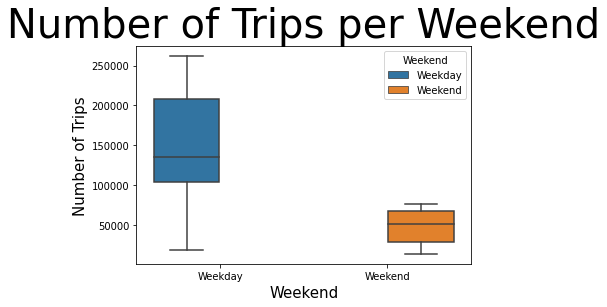

In [18]:
sns.boxplot(data=hourly_df, y = "Number of Trips", x = "Weekend", hue="Weekend")
plt.title("Number of Trips per Weekend")
plt.show()

Weekdays appears to be right skewed, meaning that the mean is larger than the median for weekdays. Therefore, there are more hours with low travel times, but a few outliers. Weekends appears to be roughly normally distributed. As predicted, there are significantly more total weekday trips than weekend trips.

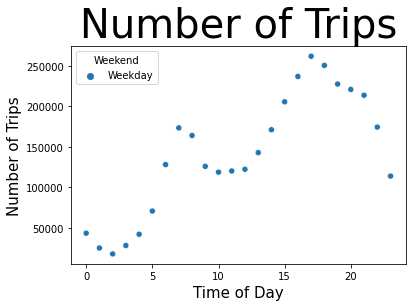

In [19]:
sns.scatterplot(data=hourly_weekdays_df, x = "Time of Day", y = "Number of Trips", hue="Weekend")
plt.title("Number of Trips")
plt.show()

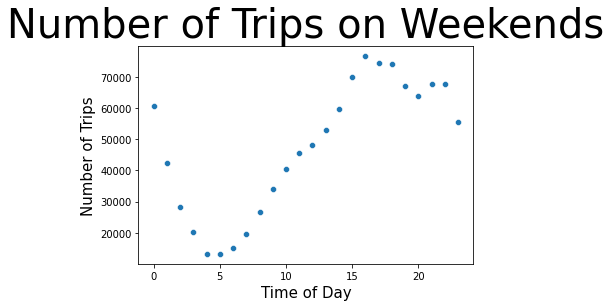

In [20]:
sns.scatterplot(data=hourly_weekends_df, x = "Time of Day", y = "Number of Trips")
plt.title("Number of Trips on Weekends")
plt.show()

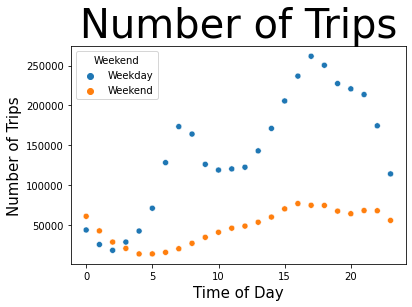

In [21]:
sns.scatterplot(data=hourly_df, x = "Time of Day", y = "Number of Trips", hue="Weekend")
plt.title("Number of Trips")
plt.show()

Looking at the plot with both weekends and weekdays, we can see a few major differences. For one thing, there are differences in the peaks. During weekends, there is a high peak at midnight and the early hours of the day. This may indicate going home from places such as bars on weekends, or generally late night partying. Generally, the peaks on weekends correspond to late night/early afternoon. Although weekdays also have peaks in the number of trips in the late afternoon, there is also a significantly higher number of trips between 6-9am, which may be people commuting to work. For both weekends and weekdays, traffic is highest between 4-6pm. There appears to be significantly higher numbers of people taking Ubers after work as opposed to before work.

In [22]:
stats.ttest_ind(a = hourly_weekends_df["Number of Trips"], b = hourly_weekdays_df["Number of Trips"])

Ttest_indResult(statistic=-5.888567978030476, pvalue=4.252739431747199e-07)

The mean number of trips on weekends is significantly higher than the mean number of trips on weekdays.

# Daily Differences Between Weekdays and Weekends
The next thing that I am going to analyze is the difference between weekdays and weekends among the Uber data.

In [23]:
daily = df.withColumn("Date/Time", F.date_trunc('dd', F.col('Date/Time')))
daily.show()

+-------------------+-------+--------+------+---------+-------+-----+
|          Date/Time|    Lat|     Lon|  Base|DayOfWeek|Weekend|Count|
+-------------------+-------+--------+------+---------+-------+-----+
|2014-09-01 00:00:00|40.2201|-74.0021|B02512|        2|Weekday|    1|
|2014-09-01 00:00:00|  40.75|-74.0027|B02512|        2|Weekday|    1|
|2014-09-01 00:00:00|40.7559|-73.9864|B02512|        2|Weekday|    1|
|2014-09-01 00:00:00| 40.745|-73.9889|B02512|        2|Weekday|    1|
|2014-09-01 00:00:00|40.8145|-73.9444|B02512|        2|Weekday|    1|
|2014-09-01 00:00:00|40.6735|-73.9918|B02512|        2|Weekday|    1|
|2014-09-01 00:00:00|40.7471|-73.6472|B02512|        2|Weekday|    1|
|2014-09-01 00:00:00|40.6613|-74.2691|B02512|        2|Weekday|    1|
|2014-09-01 00:00:00|40.3745|-73.9999|B02512|        2|Weekday|    1|
|2014-09-01 00:00:00|40.7633|-73.9773|B02512|        2|Weekday|    1|
|2014-09-01 00:00:00|40.7467|-73.6131|B02512|        2|Weekday|    1|
|2014-09-01 00:00:00

In [24]:
daily = daily.groupBy(F.col("Date/Time").alias("Day"), F.col("Weekend")).agg(F.sum("Count").alias("Number of Trips"))
daily.show()

+-------------------+-------+---------------+
|                Day|Weekend|Number of Trips|
+-------------------+-------+---------------+
|2014-08-05 00:00:00|Weekday|          28094|
|2014-09-12 00:00:00|Weekday|          39540|
|2014-08-06 00:00:00|Weekday|          30495|
|2014-08-25 00:00:00|Weekday|          22093|
|2014-07-01 00:00:00|Weekday|          21228|
|2014-09-05 00:00:00|Weekday|          42319|
|2014-07-16 00:00:00|Weekday|          28607|
|2014-09-03 00:00:00|Weekday|          32631|
|2014-09-13 00:00:00|Weekend|          43205|
|2014-08-13 00:00:00|Weekday|          29788|
|2014-08-09 00:00:00|Weekend|          26286|
|2014-08-17 00:00:00|Weekend|          21209|
|2014-09-10 00:00:00|Weekday|          35910|
|2014-07-30 00:00:00|Weekday|          30740|
|2014-09-18 00:00:00|Weekday|          40274|
|2014-09-08 00:00:00|Weekday|          30360|
|2014-07-20 00:00:00|Weekend|          21212|
|2014-07-24 00:00:00|Weekday|          32050|
|2014-09-16 00:00:00|Weekday|     

In [ ]:
daily_df = daily.toPandas()

In [ ]:
sns.lineplot(data=daily_df, x="Day", y = "Number of Trips", hue="Weekend")
plt.title("Number of Trips per Day")
plt.show()

In [ ]:
daily_weekends_df = daily_df[daily_df["Weekend"] == "Weekend"]
daily_weekends_df.head()

In [ ]:
daily_weekdays_df = daily_df[daily_df["Weekend"] == "Weekday"]
daily_weekdays_df.head()

In [ ]:
y=np.array(daily_weekdays_df['Number of Trips'].dropna().values, dtype=float)
x=np.array(pd.to_datetime(daily_weekdays_df['Day'].dropna()).index.values, dtype=float)
slope, intercept, r_value, p_value, std_err =stats.linregress(x,y)
xf = np.linspace(min(x),max(x),len(x))
xf1 = xf.copy()
xf1 = pd.to_datetime(xf1)
yf = (slope*xf)+intercept
print('r = ', r_value, '\n', 'p = ', p_value, '\n', 's = ', std_err)

In [ ]:
(slope, intercept)

In [ ]:
sns.lineplot(x=daily_weekdays_df["Day"], y=yf, palette="viridian")
sns.lineplot(x=daily_weekdays_df["Day"], y=daily_weekdays_df["Number of Trips"])
plt.show()

We can expect that for every new weekday, there will be 65 more Uber rides.

In [ ]:
y=np.array(daily_df['Number of Trips'].dropna().values, dtype=float)
x=np.array(pd.to_datetime(daily_df['Day'].dropna()).index.values, dtype=float)
slope, intercept, r_value, p_value, std_err =stats.linregress(x,y)
xf = np.linspace(min(x),max(x),len(x))
xf1 = xf.copy()
xf1 = pd.to_datetime(xf1)
yf = (slope*xf)+intercept
print('r = ', r_value, '\n', 'p = ', p_value, '\n', 's = ', std_err)

In [ ]:
sns.lineplot(x=daily_df["Day"], y=yf)
sns.lineplot(x=daily_df["Day"], y=daily_df["Number of Trips"], palette=['r', 'g'])
plt.show()